# 6. National Forest Inventory (18 points) [Christian]

## 6.1 Data loading

In [1]:
n_cv = 5
n_jobs = 4
random_state = 4 # my lucky number :-)

### Download and read data

In [2]:
import os
import requests
import pandas as pd

filename = 'NFI_filtered_cleaned.csv'
filepath = os.path.join('data', filename)

url_data = 'https://raw.githubusercontent.com/christian-igel/ML/main/data/' + filename

# Download data if not available locally
if not os.access(filepath, os.R_OK):
    print('downloading', url_data)
    try:
        r = requests.get(url_data)
        r.raise_for_status()
        open(filepath, 'wb').write(r.content)
    except Exception as e:
        print('download failed:', e)

# Read data
df = pd.read_csv(filepath)
df.to_csv(filepath, index=False)

### Split dataset
The data comes in a training, test, and validation split. Combine training- and validation set into a single data frame, for tasks that don't require a validation set.

The property `C_frac` is not used as an input feature. It give the fraction of conifer trees in the subplot. The data are filtered so that `C_frac` is either zero or one. This feature can be used to classify the subplot into broadleaf or confier.

In [3]:
regression_target = 'BMag_ha'
classification_target = 'C_frac'

### All features ###
all_features = ['h_mean_1_', 'h_mean_2_', 'h_std_1_', 'h_std_2_', 'h_coov_1_', 'h_coov_2_', 'h_skew_1_', 'h_skew_2_',
            'IR_', 'h_q5_1_', 'h_q10_1_', 'h_q25_1_', 'h_q50_1_', 'h_q75_1_', 'h_q90_1_', 'h_q95_1_', 'h_q99_1_', 
            'h_q5_2_', 'h_q10_2_', 'h_q25_2_', 'h_q50_2_', 'h_q75_2_', 'h_q90_2_', 'h_q95_2_', 'h_q99_2_', 'red_q75', 
            'red_q50', 'red_q25', 'blue_q75', 'blue_q50', 'blue_q25', 'green_q75', 'green_q50', 'green_q25']

df_all = df[all_features + [regression_target, 'split']]

df_trainval_all = df_all.query("split == ['train', 'val']")
df_train_all = df_all.query("split == 'train'")
df_val_all = df_all.query("split == 'val'")
df_test_all = df_all.query("split == 'test'")

X_trainval_all = df_trainval_all[all_features]
X_train_all = df_train_all[all_features]
X_val_all = df_val_all[all_features]
X_test_all = df_test_all[all_features]

y_trainval_all = df_trainval_all[[regression_target]].values.ravel()
y_train_all = df_train_all[[regression_target]].values.ravel()
y_val_all = df_val_all[[regression_target]].values.ravel()
y_test_all = df_test_all[[regression_target]].values.ravel()
####################

### Only mean feature ###
mean_feature = ['h_mean_1_']
df_mean = df[mean_feature + [regression_target, 'split']]

df_trainval_mean = df_mean.query("split == ['train', 'val']")
df_train_mean = df_mean.query("split == 'train'")
df_val_mean = df_mean.query("split == 'val'")
df_test_mean = df_mean.query("split == 'test'")

X_trainval_mean = df_trainval_mean[mean_feature]
X_train_mean = df_train_mean[mean_feature]
X_val_mean = df_val_mean[mean_feature]
X_test_mean = df_test_mean[mean_feature]

y_trainval_mean = df_trainval_mean[[regression_target]].values.ravel()
y_train_mean = df_train_mean[[regression_target]].values.ravel()
y_val_mean = df_val_mean[[regression_target]].values.ravel()
y_test_mean = df_test_mean[[regression_target]].values.ravel()

### Data Exploration Analysis

### Summary of data

In [4]:
df_all.describe()

,h_mean_1_,h_mean_2_,h_std_1_,h_std_2_,h_coov_1_,h_coov_2_,h_skew_1_,h_skew_2_,IR_,h_q5_1_,...,red_q75,red_q50,red_q25,blue_q75,blue_q50,blue_q25,green_q75,green_q50,green_q25,BMag_ha
count,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,...,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000
mean,7.409585,10.662752,5.105565,3.577681,1.051682,0.368356,0.288754,-0.315015,0.627030,0.425943,...,26017.967047,22139.944233,18636.451204,22296.699620,19473.237009,16995.629911,25513.125475,21920.365019,18655.026616,113.640865
std,5.411430,5.781779,2.692018,1.783427,0.852839,0.140408,1.561340,0.909943,0.253849,2.039715,...,8418.392339,8326.425086,8049.423340,7008.356714,6988.936708,6880.897220,7293.151396,7354.904510,7232.853660,104.941748
min,0.007347,1.117059,0.071730,0.000000,0.075114,0.000000,-13.816676,-3.747779,0.000137,-0.170000,...,256.000000,0.000000,0.000000,256.000000,0.000000,0.000000,256.000000,0.000000,0.000000,0.002059
25%,2.906589,5.994878,3.073276,2.330300,0.567644,0.272190,-0.627047,-0.845669,0.448131,-0.020000,...,19712.000000,16384.000000,12800.000000,17600.000000,14848.000000,12544.000000,20224.000000,16640.000000,13568.000000,28.934917
50%,6.438852,10.085121,4.823045,3.371879,0.835525,0.352517,0.095032,-0.389580,0.680277,-0.010000,...,25856.000000,22016.000000,18432.000000,22016.000000,19200.000000,16640.000000,25344.000000,21760.000000,18688.000000,86.230206
75%,10.894731,14.578052,6.953171,4.658597,1.272893,0.435651,0.947310,0.161931,0.834494,0.000000,...,31744.000000,28160.000000,24320.000000,26368.000000,23552.000000,20992.000000,30272.000000,26880.000000,23552.000000,169.278397
max,31.577832,31.654262,14.545132,12.496709,13.132664,1.359926,18.965810,7.757708,1.000000,28.080000,...,53376.000000,51200.000000,51200.000000,53376.000000,50176.000000,50176.000000,53376.000000,47104.000000,44288.000000,956.210950


### Correlation matrix

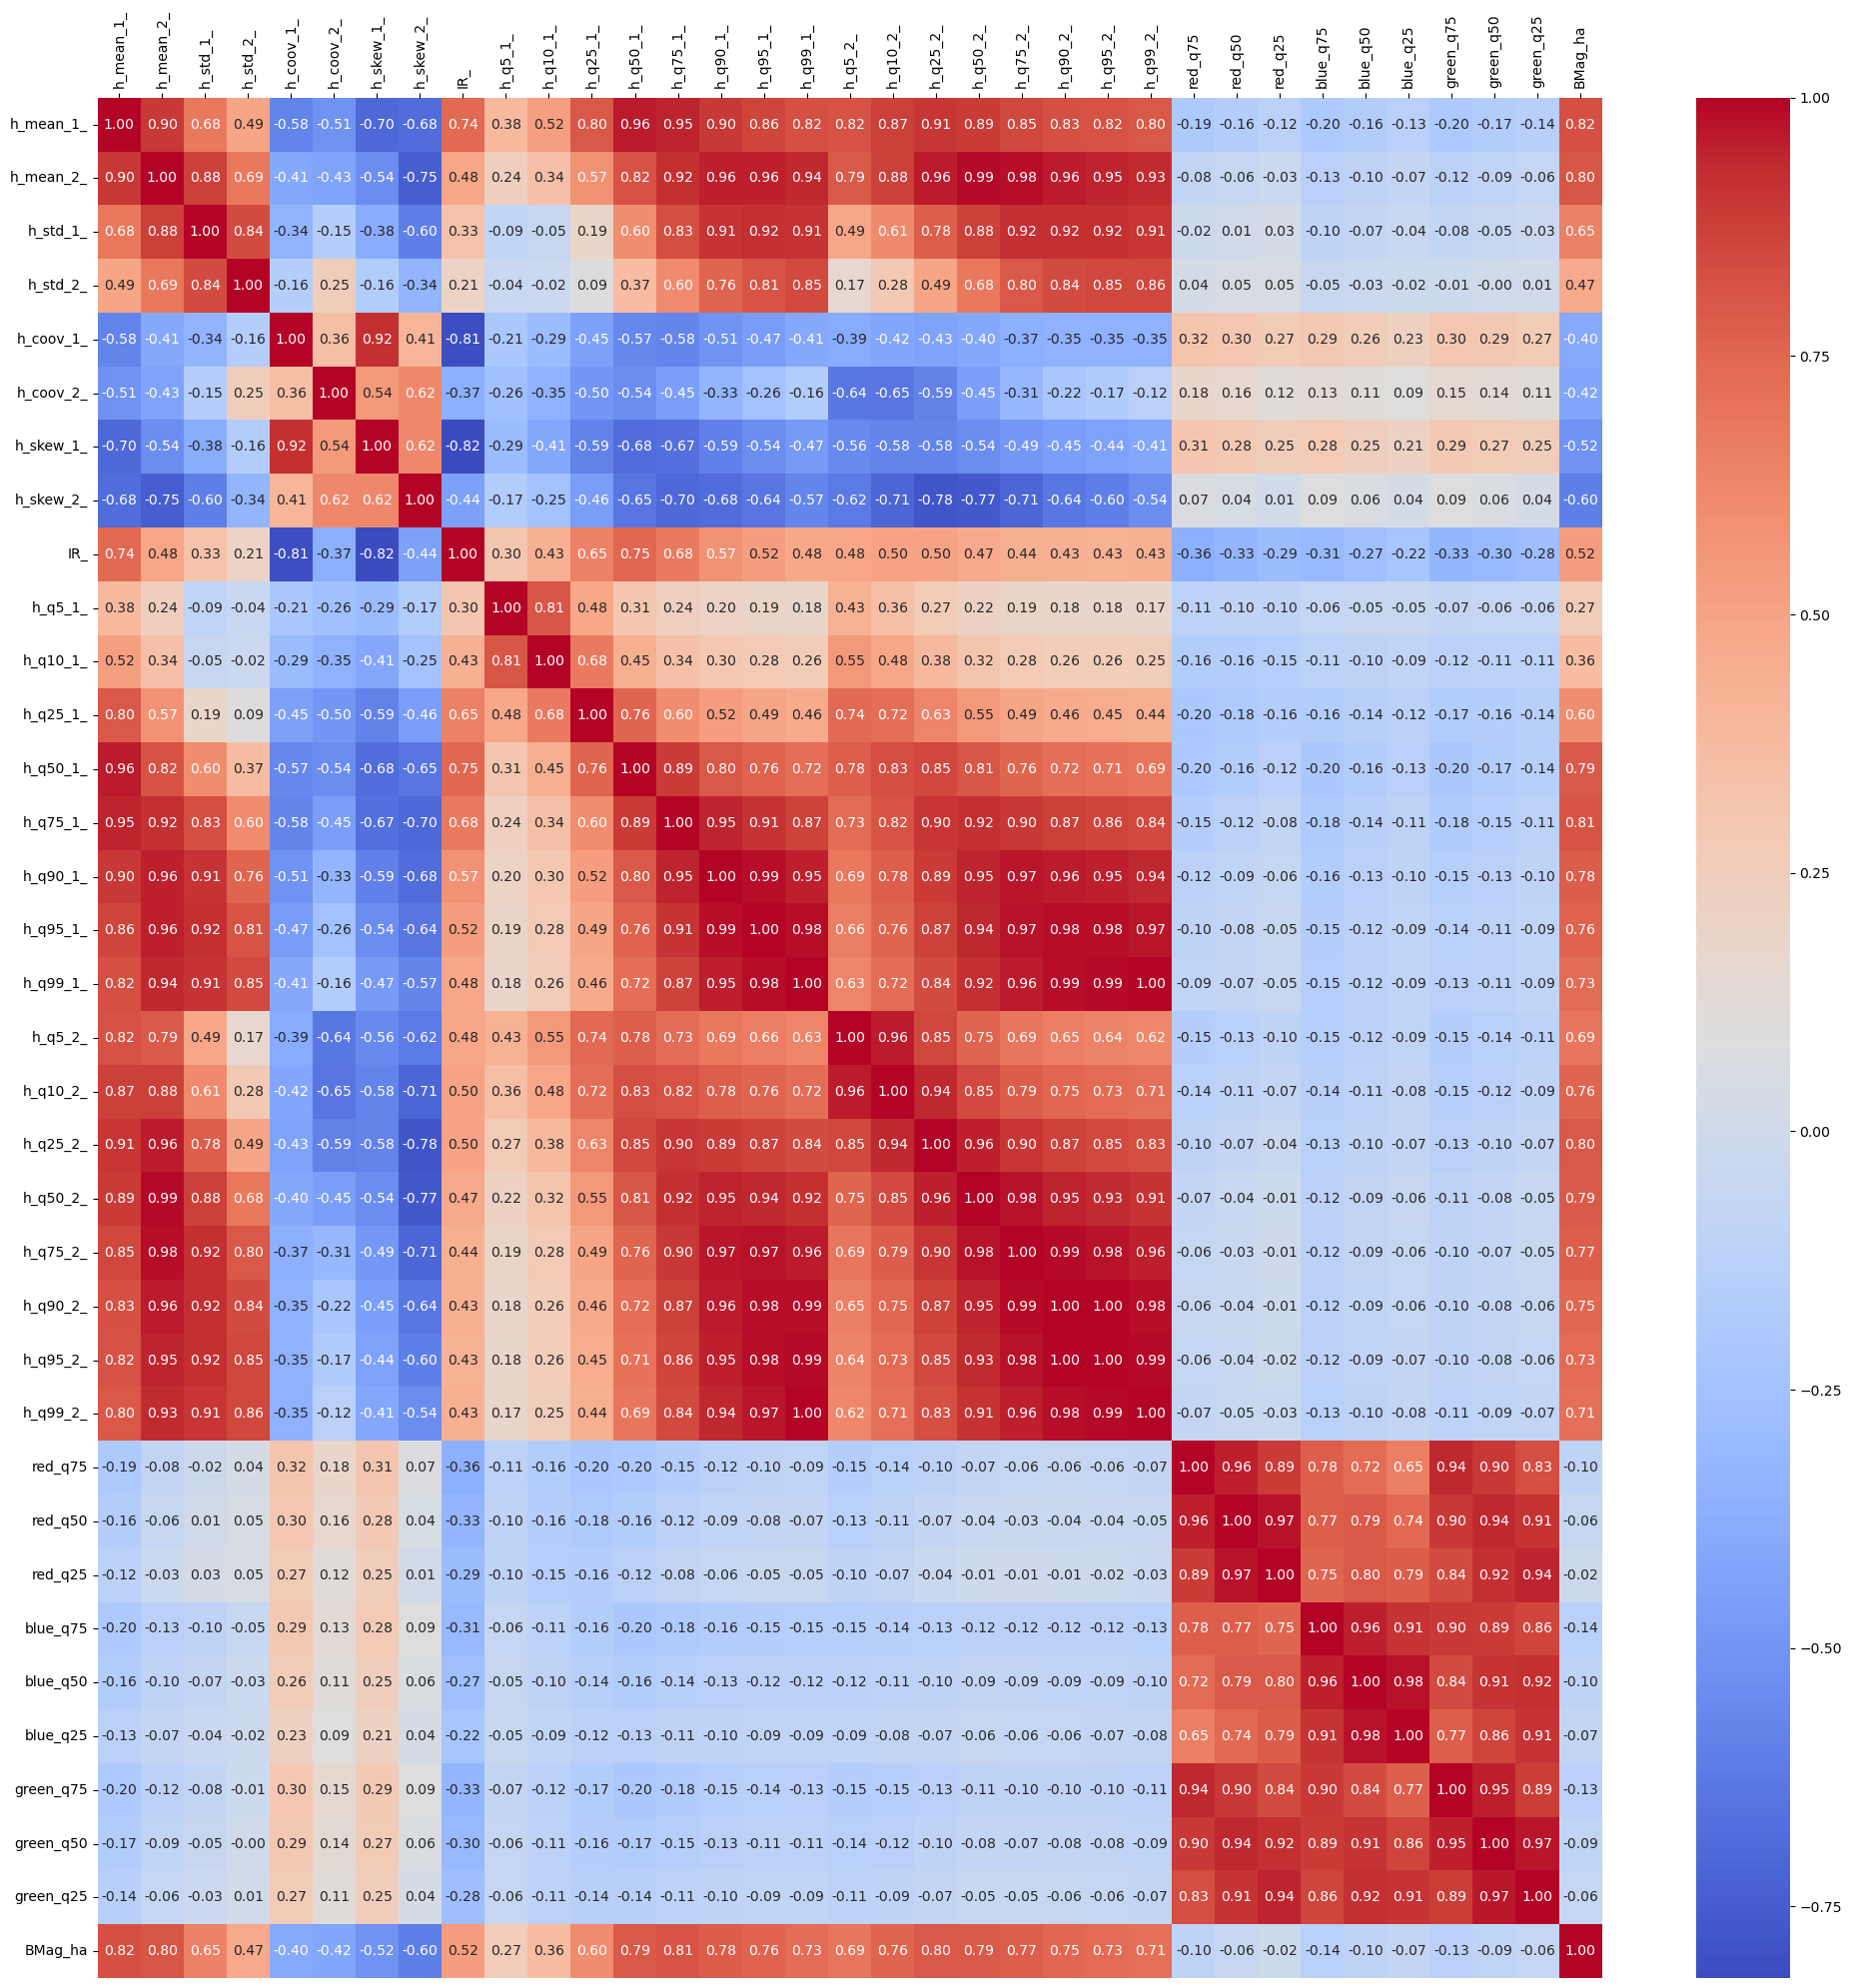

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation = df_all[all_features + [regression_target]].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
ax = plt.gca()
ax.xaxis.tick_top() # move labels to the top
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Plot two correlated features - h_mean_1_ vs. h_mean_2_

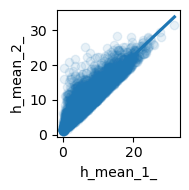

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 2))
sns.regplot(x='h_mean_1_', y='h_mean_2_', data=df_all, scatter_kws={'alpha': 0.1})
plt.tight_layout()
plt.show()

### Plot h_mean_1_ against BMag_ha

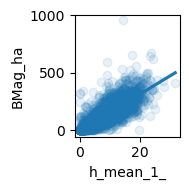

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 2))
sns.regplot(x='h_mean_1_', y=regression_target, data=df_all, scatter_kws={'alpha': 0.1})
plt.tight_layout()
plt.show()

#### Remove one feature at a time showing that h_mean_1_ can be used only

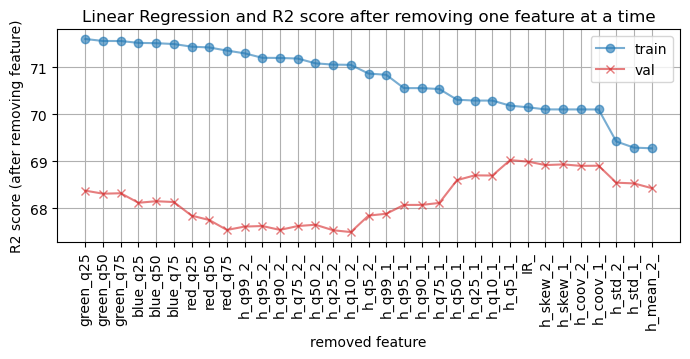

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression(n_jobs=n_jobs)

# Remove one feature at a time
remaining_features = all_features.copy()
removed_features = []
r2_train = []
r2_val = []
while len(remaining_features) > 1:
    # Fit the model
    lr.fit(X_train_all[remaining_features], y_train_all)

    # Predict on both the training- and validation set
    y_train_pred = lr.predict(X_train_all[remaining_features])
    y_val_pred = lr.predict(X_val_all[remaining_features])

    # Store R2 scores
    r2_train.append(r2_score(y_train_all, y_train_pred)*100)
    r2_val.append(r2_score(y_val_all, y_val_pred)*100)

    # Remove one feature
    removed_feature = remaining_features.pop()
    removed_features.append(removed_feature)

# Plot the results
plt.figure(figsize=(7, 3.7))
plt.plot(removed_features, r2_train, marker='o', label="train", color='tab:blue', alpha=0.6)
plt.plot(removed_features, r2_val, marker='x', label="val", color='tab:red', alpha=0.6)
plt.xticks(rotation=90)
plt.xlabel('removed feature')
plt.ylabel('R2 score (after removing feature)')
plt.legend()
plt.title('Linear Regression and R2 score after removing one feature at a time')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6.2 Regression

#### Final evaluation method be used for the different approaches using the validation or test set

In [9]:
from sklearn.metrics import r2_score

def model_evaluation(best_model, X_test, y_test, best_params=None, title=None):
    # Predict with the best model provided
    y_test_pred = best_model.predict(X_test)

    # Print best parameters if provided
    if best_params:
        print(f'Best parameters: {best_params}')

    # Calculate R2 score
    r2 = r2_score(y_test, y_test_pred)*100

    # Print R2 score
    print(f'R2 score ({title}): {r2:.3f}')

    return r2

### 1. Linear Regression without regularization

In [10]:
from sklearn.linear_model import LinearRegression

# All features
lr_all = LinearRegression(n_jobs=n_jobs)
lr_all.fit(X_train_all, y_train_all)
r2_all = model_evaluation(lr_all, X_val_all, y_val_all, title='all features, val set')

# Only mean feature
lr_mean = LinearRegression(n_jobs=n_jobs)
lr_mean.fit(X_train_mean, y_train_mean)
r2_mean = model_evaluation(lr_mean, X_val_mean, y_val_mean, title='only mean, val set')

# Find the best model and make a final evaluation on the test set
if r2_all >= r2_mean:
    print("\nBest is to use all features")
    model_evaluation(lr_all, X_test_all, y_test_all, title='all features, test set')
else:
    print("\nBest is use only mean feature")
    model_evaluation(lr_mean, X_test_mean, y_test_mean, title='only mean, test set')

R2 score (all features, val set): 68.379
R2 score (only mean, val set): 66.288

Best is to use all features
R2 score (all features, test set): 73.785


###

### 2. Random forest with 100 and 1000 trees

oob-score with #trees=100 (train+val set, all features) and best-found max_depth=6: 69.125
oob-score with #trees=1000 (train+val set, all features) and best-found max_depth=5: 69.086


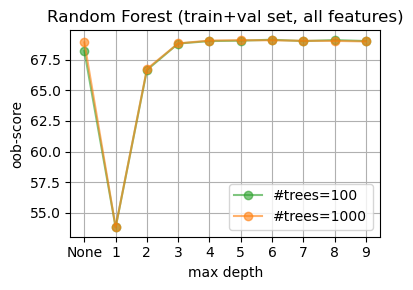

oob-score with #trees=100 (train+val set, only mean) and best-found max_depth=3: 66.270
oob-score with #trees=1000 (train+val set, only mean) and best-found max_depth=3: 66.361


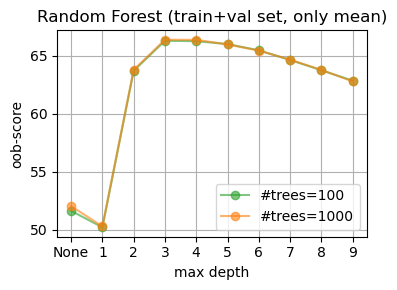


Best is to use all features
Best parameters: {'n_estimators': 100, 'max_depth': 6}
R2 score (test set, all features): 72.019


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate

# Define hyperparameters
rf_param = {
    'n_estimators': [100, 1000],
    'max_depth': [None, *range(1, 10)]
}

def random_forest(X_trainval, y_trainval, title=None):
    # Iterate over all combinations of hyperparameters
    overall_best_params = None
    overall_best_oob_score = -np.inf
    results = []
    for n_est in rf_param['n_estimators']:
        current_results = []
        current_best_params = None
        current_best_oob_score = -np.inf
        for max_depth in rf_param['max_depth']:
            # Define and fit model with oob_score (out-of-bag score, which per default set score to R2)
            rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=random_state, n_jobs=n_jobs, n_estimators=n_est, max_depth=max_depth)
            rf.fit(X_trainval, y_trainval)
            
            # Store results
            results.append({'n_estimators': n_est, 'max_depth': max_depth, 'oob_score': rf.oob_score_})

            # Store best hyperparameters if oob_score is better than previous best
            if rf.oob_score_ > current_best_oob_score:
                current_best_oob_score = rf.oob_score_
                current_best_params = {'n_estimators': n_est, 'max_depth': max_depth}
            if rf.oob_score_ > overall_best_oob_score:
                overall_best_oob_score = rf.oob_score_
                overall_best_params = {'n_estimators': n_est, 'max_depth': max_depth}
        
        # Print best oob-score for current #trees
        print(f'oob-score with #trees={n_est} ({title}) and best-found max_depth={current_best_params["max_depth"]}: {current_best_oob_score*100:.3f}')
        
    # Plot results
    plt.figure(figsize=(4, 3))
    colors = ['tab:green', 'tab:orange']
    for idx, n_est in enumerate(rf_param['n_estimators']):
        current_results = [result for result in results if result['n_estimators'] == n_est]
        depths = [result['max_depth'] if result['max_depth'] is not None else 0 for result in current_results]
        oob_scores = [result['oob_score']*100 for result in current_results]
        plt.plot(depths, oob_scores, marker='o', label=f'#trees={n_est}', color=colors[idx], alpha=0.6)
    plt.xticks(list(range(0, 10)), ["None"] + list(range(1, 10))) # represent 0 as "Unlimited"
    plt.xlabel('max depth')
    plt.ylabel('oob-score')
    plt.legend()
    plt.title(f'Random Forest ({title})')
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    
    return overall_best_oob_score, overall_best_params

# Find the best model of either using all features or only mean feature
rf_all_oob_score, rf_all_best_params = random_forest(X_trainval_all, y_trainval_all, title='train+val set, all features')
rf_mean_oob_score, rf_mean_best_params = random_forest(X_trainval_mean, y_trainval_mean, title='train+val set, only mean')

# Make a final evaluation on the test set by taking the best found oob_score
if rf_all_oob_score >= rf_mean_oob_score:
    print("\nBest is to use all features")
    rf_all = RandomForestRegressor(**rf_all_best_params, oob_score=True, random_state=random_state, n_jobs=n_jobs)
    rf_all.fit(X_trainval_all, y_trainval_all)
    model_evaluation(rf_all, X_test_all, y_test_all, best_params=rf_all_best_params, title='test set, all features')
else:
    print("\nBest is to use only mean feature")
    rf_mean = RandomForestRegressor(**rf_mean_best_params, oob_score=True, random_state=random_state, n_jobs=n_jobs)
    rf_mean.fit(X_trainval_mean, y_trainval_mean)
    model_evaluation(rf_mean, X_test_mean, y_test_mean, best_params=rf_mean_best_params, title='test set, only mean')

### 3. $k$-nearest-neighbor regression with and without normalization

#### Evaluate the performance of KNN using the training- and validation set

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def knn_results(grid_search, title):
    n_neighbors = np.array([0 if v is None else v for v in grid_search.cv_results_[f'param_n_neighbors'].data], dtype=float)
    
    # Get R2 scores and standard deviation for train- and validation set, then multiply by 100 to get percentages
    train_r2_scores = np.array(grid_search.cv_results_['mean_train_score'], dtype=float) * 100
    vali_r2_scores = np.array(grid_search.cv_results_['mean_test_score'], dtype=float) * 100
    train_std = np.array(grid_search.cv_results_['std_train_score'], dtype=float) * 100
    vali_std = np.array(grid_search.cv_results_['std_test_score'], dtype=float) * 100

    # Print best hyperparameters and R2 score for best model
    r2 = grid_search.best_score_*100
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best R2 score (train+val set, {title}): {r2:.3f}')

    # Plot results
    plt.figure(figsize=(4, 3))
    plt.plot(n_neighbors, train_r2_scores, label='train', color='tab:blue', alpha=0.6)
    plt.fill_between(n_neighbors, train_r2_scores - train_std, train_r2_scores + train_std, color='tab:blue', alpha=0.25)
    plt.plot(n_neighbors, vali_r2_scores, label='val', color='tab:red', alpha=0.6)
    plt.fill_between(n_neighbors, vali_r2_scores - vali_std, vali_r2_scores + vali_std, color='tab:red', alpha=0.15)
    plt.xlabel('#neighbors')
    plt.ylabel('R2 score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return r2

#### KNN model and grid search parameters

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Define hyperparameters
knn_param = {
    'n_neighbors': list(range(1, 50, 2)) # step by 2, i.e. only odd numbers (majority vote, no ties)
}

# Define scaler to scale data before knn
scaler = StandardScaler()

Best parameters: {'n_neighbors': 21}
Best R2 score (train+val set, all features (unnormalized)): 6.491


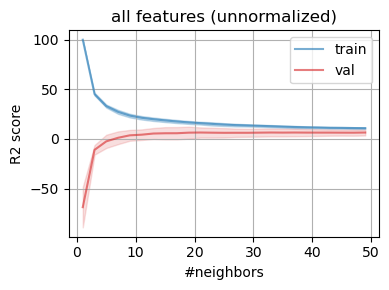

Best parameters: {'n_neighbors': 41}
Best R2 score (train+val set, all features (normalized)): 68.653


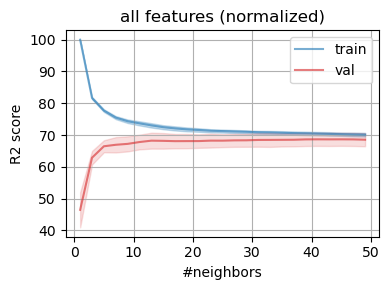

Best parameters: {'n_neighbors': 45}
Best R2 score (train+val set, only mean feature (unnormalized)): 65.469


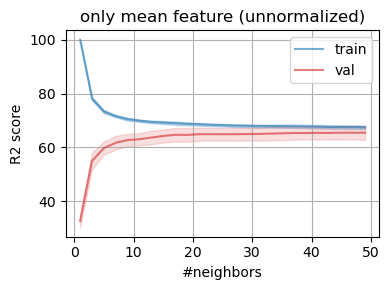

Best parameters: {'n_neighbors': 45}
Best R2 score (train+val set, only mean feature (normalized)): 65.469


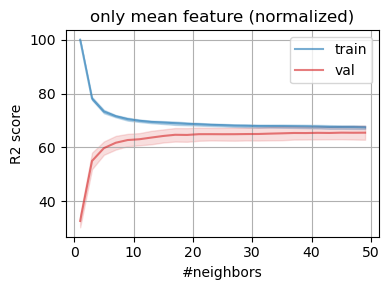

Overall best is using all features (normalized)
R2 score (test set, all features (normalized)): 73.168


In [14]:
from sklearn.base import clone

knn_grid_search = GridSearchCV(estimator=KNeighborsRegressor(n_jobs=n_jobs),
                               param_grid=knn_param,
                               cv=n_cv,
                               n_jobs=n_jobs,
                               return_train_score=True,
                               scoring='r2')

# Using all features (unnormalized)
knn_grid_search_all_unnormalized = clone(knn_grid_search)
knn_grid_search_all_unnormalized.fit(X_trainval_all, y_trainval_all)
r2_all_unnormalized = knn_results(knn_grid_search_all_unnormalized, 'all features (unnormalized)')

# Using all features (normalized)
knn_grid_search_all_normalized = clone(knn_grid_search)
X_trainval_all_normalized = scaler.fit_transform(X_trainval_all)
X_test_all_normalized = scaler.transform(X_test_all)
knn_grid_search_all_normalized.fit(X_trainval_all_normalized, y_trainval_all)
r2_all_normalized = knn_results(knn_grid_search_all_normalized, 'all features (normalized)')

# Using only mean feature (unnormalized)
knn_grid_search_mean_unnormalized = clone(knn_grid_search)
knn_grid_search_mean_unnormalized.fit(X_trainval_mean, y_trainval_mean)
r2_mean_unnormalized = knn_results(knn_grid_search_mean_unnormalized, 'only mean feature (unnormalized)')

# Using only mean feature (normalized)
knn_grid_search_mean_normalized = clone(knn_grid_search)
X_trainval_mean_normalized = scaler.fit_transform(X_trainval_mean)
X_test_mean_normalized = scaler.transform(X_test_mean)
knn_grid_search_mean_normalized.fit(X_trainval_mean_normalized, y_trainval_mean)
r2_mean_normalized = knn_results(knn_grid_search_mean_normalized, 'only mean feature (normalized)')

# Make a final evaluation on the test set by taking the best found R2 score
best_score = max(r2_all_unnormalized, r2_all_normalized, r2_mean_unnormalized, r2_mean_normalized)
if best_score == r2_all_unnormalized:
    title = 'all features (unnormalized)'
    print('Overall best is using', title)
    model_evaluation(knn_grid_search_all_unnormalized.best_estimator_, X_test_all, y_test_all, title='test set, '+title)
elif best_score == r2_all_normalized:
    title = 'all features (normalized)'
    print('Overall best is using', title)
    model_evaluation(knn_grid_search_all_normalized.best_estimator_, X_test_all_normalized, y_test_all, title='test set, '+title)
elif best_score == r2_mean_unnormalized:
    title = 'only mean feature (unnormalized)'
    print('Overall best is using', title)
    model_evaluation(knn_grid_search_mean_unnormalized.best_estimator_, X_test_mean, y_test_mean, title='test set, '+title)
else:
    title = 'only mean feature (normalized)'
    print('Overall best is using', title)
    model_evaluation(knn_grid_search_mean_normalized.best_estimator_, X_test_mean_normalized, y_test_mean, title='test set, '+title)

# 7. Clustering (20 points) [Sadegh]

![fig2](images/figure2.png)

In [15]:
import numpy as np

data = {
    'A': np.array([25., 0.]),
    'B': np.array([0., 3.]),
    'C': np.array([0., -3.]),
    'D': np.array([-25., 1.]),
    'E': np.array([-25., -1.]),
}

## 2. Conditioned on $C$ being chosen as $c_1$, how does the algorithm choose $c_2$?

In [16]:
import numpy as np
from tabulate import tabulate

def kmeans_plusplus_initialization(data, initial_centroids=[]):
    centroids_indices = initial_centroids.copy()
    total_centroids = len(initial_centroids) + 1

    for _ in range(total_centroids - len(initial_centroids)):
        squared_distances = []
        nearest_distances = []

        # Distance D(x) for each data point
        for point_name in data:
            distances_to_centroids = [np.linalg.norm(data[point_name] - data[c]) for c in centroids_indices]
            nearest_distance = min(distances_to_centroids)
            nearest_distances.append(nearest_distance)
            squared_distances.append(nearest_distance ** 2)

        # Weighted probability
        total_squared_distance = sum(squared_distances)
        probabilities = [d / total_squared_distance for d in squared_distances]
        
        # Print distances and probabilities for the next cluster center (centroid)
        print(f"\nDistances and Probabilities for choosing cluster center (centroid) c{len(centroids_indices) + 1}:")
        table_data = []
        for point_name, dist, prob in zip(data.keys(), nearest_distances, probabilities):
            table_data.append([point_name, dist, prob])
        headers = ["Point", "Distance", "Probability"]
        print(tabulate(table_data, headers=headers, floatfmt=(".3f", ".3f", ".3f")))

        # Choose new center with weighted probability
        next_centroid = np.random.choice(list(data.keys()), p=probabilities)
        centroids_indices.append(next_centroid)

In [17]:
kmeans_plusplus_initialization(data, ['C'])


Distances and Probabilities for choosing cluster center (centroid) c2:
Point      Distance    Probability
-------  ----------  -------------
A            25.179          0.327
B             6.000          0.019
C             0.000          0.000
D            25.318          0.330
E            25.080          0.324


## 3. Conditioned on $c_2 = A$ and $c_1 = C$, how does the algorithm choose $c_3$?

In [18]:
kmeans_plusplus_initialization(data, ['C', 'A'])


Distances and Probabilities for choosing cluster center (centroid) c3:
Point      Distance    Probability
-------  ----------  -------------
A             0.000          0.000
B             6.000          0.028
C             0.000          0.000
D            25.318          0.491
E            25.080          0.482


## 4. Suppose that the algorithm chooses $c_1 = C$, $c_2 = A$, $c_3 = D$. Determine the final clustering returned by `k-means++` based on these initial cluster centers (i.e., determine the final clustering and the associated cluster centers).

In [19]:
import numpy as np
from tabulate import tabulate

def kmeans(data, initial_centroids):
    centroids = np.array([data[point] for point in initial_centroids])
    prev_centroids = np.zeros(centroids.shape)
    clusters = {i: [] for i in range(len(centroids))}
    iteration = 1
    
    # Continue until centroids converge
    while not np.array_equal(centroids, prev_centroids):
        print(f"\nIteration {iteration}:\n{'-' * 20}")
        clusters = {i: [] for i in range(len(centroids))}

        # Assignment step
        table_data = []
        for point_name, point_coords in data.items():
            distances = np.linalg.norm(point_coords - centroids, axis=1)
            cluster_index = np.argmin(distances)
            clusters[cluster_index].append(point_name)
            table_data.append([point_name] + list(distances))
        headers = ["Point"] + [f"c{i+1}" for i in range(len(centroids))]
        print(tabulate(table_data, headers=headers, floatfmt=".3f"))        

        # Update step
        for i, point_names in clusters.items():
            print(f"Cluster C{i+1}: {point_names}")
        
        prev_centroids = centroids.copy()
        for i, point_names in clusters.items():
            if point_names:
                new_centroid = np.mean([data[pn] for pn in point_names], axis=0)
                centroids[i] = new_centroid
                print(f"Updated cluster center (centroid), c{i+1}: from [{prev_centroids[i][0]:.3f}, "
                      f"{prev_centroids[i][1]:.3f}] to [{new_centroid[0]:.3f}, {new_centroid[1]:.3f}]")
        
        iteration += 1
    
    # Cost function, sum of squared distances
    cost = 0
    for i, point_names in clusters.items():
        for point_name in point_names:
            cost += np.linalg.norm(data[point_name] - centroids[i]) ** 2
    print(f"\nCost: {cost:.3f}")
    
    # Display final results
    print("\nFinal Results:\n" + '-' * 20)
    for i, point_names in clusters.items():
        print(f"Cluster C{i+1}: {point_names}")
    for i, centroid in enumerate(centroids):
        formatted_centroid = [f"{element:.3f}" for element in centroid]
        print(f"cluster center (centroid) c{i+1} = [{', '.join(formatted_centroid)}]")

In [20]:
kmeans(data, ['C', 'A', 'D'])


Iteration 1:
--------------------
Point        c1      c2      c3
-------  ------  ------  ------
A        25.179   0.000  50.010
B         6.000  25.179  25.080
C         0.000  25.179  25.318
D        25.318  50.010   0.000
E        25.080  50.010   2.000
Cluster C1: ['B', 'C']
Cluster C2: ['A']
Cluster C3: ['D', 'E']
Updated cluster center (centroid), c1: from [0.000, -3.000] to [0.000, 0.000]
Updated cluster center (centroid), c2: from [25.000, 0.000] to [25.000, 0.000]
Updated cluster center (centroid), c3: from [-25.000, 1.000] to [-25.000, 0.000]

Iteration 2:
--------------------
Point        c1      c2      c3
-------  ------  ------  ------
A        25.000   0.000  50.000
B         3.000  25.179  25.179
C         3.000  25.179  25.179
D        25.020  50.010   1.000
E        25.020  50.010   1.000
Cluster C1: ['B', 'C']
Cluster C2: ['A']
Cluster C3: ['D', 'E']
Updated cluster center (centroid), c1: from [0.000, 0.000] to [0.000, 0.000]
Updated cluster center (centroid), c2: 

## 5. Now suppose that $c_1 = D$, $c_2 = A$, $c_3 = E$. Repeat the previous part with these initial cluster centers.

In [21]:
kmeans(data, ['D', 'A', 'E'])


Iteration 1:
--------------------
Point        c1      c2      c3
-------  ------  ------  ------
A        50.010   0.000  50.010
B        25.080  25.179  25.318
C        25.318  25.179  25.080
D         0.000  50.010   2.000
E         2.000  50.010   0.000
Cluster C1: ['B', 'D']
Cluster C2: ['A']
Cluster C3: ['C', 'E']
Updated cluster center (centroid), c1: from [-25.000, 1.000] to [-12.500, 2.000]
Updated cluster center (centroid), c2: from [25.000, 0.000] to [25.000, 0.000]
Updated cluster center (centroid), c3: from [-25.000, -1.000] to [-12.500, -2.000]

Iteration 2:
--------------------
Point        c1      c2      c3
-------  ------  ------  ------
A        37.553   0.000  37.553
B        12.540  25.179  13.463
C        13.463  25.179  12.540
D        12.540  50.010  12.855
E        12.855  50.010  12.540
Cluster C1: ['B', 'D']
Cluster C2: ['A']
Cluster C3: ['C', 'E']
Updated cluster center (centroid), c1: from [-12.500, 2.000] to [-12.500, 2.000]
Updated cluster center (centro

## 6. Letting $\phi'$ denote the cost in the previous part, what is the approximation ratio $\phi'/\phi^\star$.

See results above.